In [1]:
# -*- coding: utf-8 -*-

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import time

import paddle
import paddle.fluid as fluid
import paddle.fluid.layers as layers

In [2]:
# 导入数据
data = pd.read_csv('data/data72449/shangzheng.csv')

In [3]:
# 查看信息
data.head()
# data.describe()
# data.info()

,date,over,begin,high,low,trade,wave
0,2000年1月4日,1406.37,1368.69,1407.52,1361.21,437.09M,2.91%
1,2000年1月5日,1409.68,1407.83,1433.78,1398.32,688.09M,0.24%
2,2000年1月6日,1463.94,1406.04,1463.95,1400.25,809.05M,3.85%
3,2000年1月7日,1516.60,1477.15,1522.83,1477.15,1.60B,3.60%
4,2000年1月10日,1545.11,1531.71,1546.72,1506.40,1.51B,1.88%


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


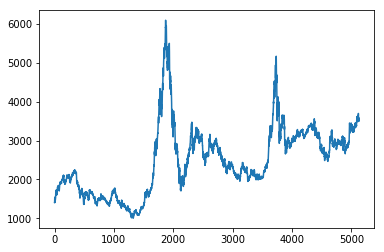

In [4]:
plt.plot(data['over'])

In [5]:
data.set_index('date', inplace=True)
data.drop(columns=['trade', 'wave'], inplace=True)
data.head()

,over,begin,high,low
date,,,,
2000年1月4日,1406.37,1368.69,1407.52,1361.21
2000年1月5日,1409.68,1407.83,1433.78,1398.32
2000年1月6日,1463.94,1406.04,1463.95,1400.25
2000年1月7日,1516.60,1477.15,1522.83,1477.15
2000年1月10日,1545.11,1531.71,1546.72,1506.40


In [6]:
sequence_length = 5
delay = 1
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=sequence_length+delay):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

data_ = create_sequences(data.values)
print("Training input shape: ", data_.shape)

Training input shape:  (5124, 6, 4)


In [7]:
split_boundary = int(data_.shape[0] * 0.8)

train = data_[: split_boundary]
test = data_[split_boundary:]

mean = train.mean(axis=0)
std = train.std(axis=0)
train = (train - mean)/std
test = (test - mean)/std

train.shape,test.shape

((4099, 6, 4), (1025, 6, 4))

In [8]:
#数据生成器
def switch_reader(is_val: bool = False):
    def reader():
        # 判断是否是验证集
        if is_val:
            # 抽取数据使用迭代器返回
            for te in test:
                yield te[:sequence_length],te[-1:][:,0]
        else:
            # 抽取数据使用迭代器返回
            for tr in train:
                yield tr[:sequence_length],tr[-1:][:,0]#只取第0列pm2.5的值为label
        
    return reader   # 注意！此处不需要带括号
# 划分batch
batch_size = 128
train_reader = fluid.io.batch(reader=switch_reader(), batch_size=batch_size)
val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=batch_size)
for data in train_reader():
    # print(data[0].shape,data[1].shape)
    train_x=np.array([x[0] for x in data],np.float32)
    train_y = np.array([x[1] for x in data]).astype('int64')
    print(train_x.shape,train_y.shape)

(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(128, 5, 4) (128, 1)
(3, 5, 4) (3, 1)


In [55]:
#定义DNN网络
class MyModel(fluid.dygraph.Layer):
    '''
    DNN网络
    '''
    def __init__(self):
        super(MyModel,self).__init__()
        self.fc1=fluid.dygraph.Linear(5*4,5,act='relu')
        self.fc2=fluid.dygraph.Linear(5,1)
        
    def forward(self,input):        # forward 定义执行实际运行时网络的执行逻辑
        '''前向计算'''
        # print('input',input.shape)
        input =fluid.layers.reshape(input,shape=[-1,5*4])
        out=self.fc1(input)
        out=self.fc2(out)
        # print(out.shape)
        return out

In [56]:
Batch=0
Batchs=[]
all_train_loss=[]
def draw_train_loss(Batchs, train_loss,eval_loss):
    # print(len(Batchs), len(train_loss), len(eval_loss))
    title="training-eval loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.plot(Batchs, eval_loss, color='g', label='eval loss')
    plt.legend()
    plt.grid()
    plt.show()

    # print(Batchs, train_loss)

epoch:0,batch_id:10,train_loss:[2.56659],eval_loss:2.86149271329244
epoch:1,batch_id:10,train_loss:[2.510707],eval_loss:2.7994899352391562
epoch:2,batch_id:10,train_loss:[2.454645],eval_loss:2.7372981309890747
epoch:3,batch_id:10,train_loss:[2.399177],eval_loss:2.675766626993815
epoch:4,batch_id:10,train_loss:[2.344496],eval_loss:2.6151060660680137
epoch:5,batch_id:10,train_loss:[2.2906551],eval_loss:2.5553739070892334
epoch:6,batch_id:10,train_loss:[2.2376661],eval_loss:2.4965792894363403
epoch:7,batch_id:10,train_loss:[2.1855283],eval_loss:2.438714941342672
epoch:8,batch_id:10,train_loss:[2.1342335],eval_loss:2.3817824920018515
epoch:9,batch_id:10,train_loss:[2.0837758],eval_loss:2.3257749875386557
epoch:10,batch_id:10,train_loss:[2.0341473],eval_loss:2.270683487256368
epoch:11,batch_id:10,train_loss:[1.9853407],eval_loss:2.216500759124756
epoch:12,batch_id:10,train_loss:[1.9373498],eval_loss:2.1632188161214194
epoch:13,batch_id:10,train_loss:[1.8901653],eval_loss:2.110829214255015
e

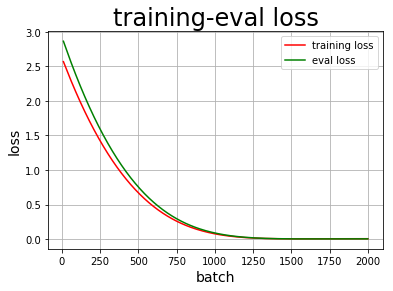

In [57]:
# place = fluid.CUDAPlace(0) #非develop版本请勿使用GPU版本
place = fluid.CPUPlace() 
with fluid.dygraph.guard(place):
    model=MyModel() #模型实例化
    model.train() #训练模式
    # opt=fluid.optimizer.SGDOptimizer(learning_rate=train_parameters['learning_strategy']['lr'], parameter_list=model.parameters())#优化器选用SGD随机梯度下降，学习率为0.001.
    opt=fluid.optimizer.AdamOptimizer(learning_rate=0.0001, parameter_list=model.parameters()) 
    epochs_num=200#迭代次数
    batch_size = 128 * 3
    train_reader = fluid.io.batch(reader=switch_reader(), batch_size=batch_size)
    val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=batch_size)
    Batch=0
    Batchs=[]
    all_train_loss=[]
    all_eval_loss=[]
    for pass_num in range(epochs_num):
        for batch_id, data in enumerate(train_reader()): 
            data_x=np.array([x[0] for x in data],np.float32)
            data_y = np.array([x[1] for x in data]).astype('float32')
            data_x = fluid.dygraph.to_variable(data_x)
            data_y = fluid.dygraph.to_variable(data_y)
        
            # print(data_x.shape, data_y.shape)

            predict=model(data_x)
            # print(predict.shape)
            loss=fluid.layers.mse_loss(predict,data_y)
            avg_loss=fluid.layers.mean(loss)#获取loss值
            avg_loss.backward()       
            opt.minimize(avg_loss)    #优化器对象的minimize方法对参数进行更新 
            model.clear_gradients()   #model.clear_gradients()来重置梯度
            if batch_id!=0 and batch_id%10==0:
                Batch = Batch+10
                Batchs.append(Batch)
                all_train_loss.append(avg_loss.numpy()[0])
                evalavg_loss=[]
                for eval_data in val_reader():
                    eval_data_x = np.array([x[0] for x in eval_data],np.float32)
                    eval_data_y = np.array([x[1] for x in eval_data]).astype('float32')

                    eval_data_x = fluid.dygraph.to_variable(eval_data_x)
                    eval_data_y = fluid.dygraph.to_variable(eval_data_y)

                    eval_predict=model(eval_data_x)
                    eval_loss=fluid.layers.mse_loss(eval_predict,eval_data_y)
                    eval_loss=fluid.layers.mean(eval_loss)
                    evalavg_loss.append(eval_loss.numpy()[0])#获取loss值
                all_eval_loss.append(sum(evalavg_loss)/len(evalavg_loss))
        print("epoch:{},batch_id:{},train_loss:{},eval_loss:{}".format(pass_num,batch_id,avg_loss.numpy(),sum(evalavg_loss)/len(evalavg_loss)))     

    fluid.save_dygraph(model.state_dict(),'MyModel')#保存模型
    fluid.save_dygraph(opt.state_dict(),'MyModel')#保存模型
    print("Final loss: {}".format(avg_loss.numpy()))    
#让我们绘制训练图和验证损失图，以了解训练的进行情况。     
draw_train_loss(Batchs,all_train_loss,all_eval_loss)

In [12]:
#定义LSTM网络
import paddle.fluid as fluid
class MyLSTMModel(fluid.dygraph.Layer):
    '''
    DNN网络
    '''
    def __init__(self):
        super(MyLSTMModel,self).__init__()
        self.rnn = paddle.nn.LSTM(4, 8, 2)
        self.flatten = paddle.nn.Flatten()
        self.fc1=fluid.dygraph.Linear(5*8,5)
        self.fc2=fluid.dygraph.Linear(5,1)

        
    def forward(self,input):        # forward 定义执行实际运行时网络的执行逻辑
        '''前向计算'''
        # print('input',input.shape)
        out, (h, c)=self.rnn(input)
        out =self.flatten(out)
        out=self.fc1(out)
        out=self.fc2(out)
        return out

In [13]:
Batch=0
Batchs=[]
all_train_loss=[]
def draw_train_loss(Batchs, train_loss,eval_loss):
    title="training-eval loss"
    plt.title(title, fontsize=24)
    plt.xlabel("batch", fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.plot(Batchs, train_loss, color='red', label='training loss')
    plt.plot(Batchs, eval_loss, color='g', label='eval loss')
    plt.legend()
    plt.grid()
    plt.show()

In [14]:
batch_size = 128*3
train_reader = fluid.io.batch(reader=switch_reader(), batch_size=batch_size)
val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=batch_size)
for data in train_reader():
    # print(data[0].shape,data[1].shape)
    train_x=np.array([x[0] for x in data],np.float32)
    train_y = np.array([x[1] for x in data]).astype('int64')
    # print(train_x.shape,train_y.shape)
for batch_id, data in enumerate(train_reader()):
    data_x=np.array([x[0] for x in data],np.float32)
    print(data_x.shape)

(384, 5, 4)
(384, 5, 4)
(384, 5, 4)
(384, 5, 4)
(384, 5, 4)
(384, 5, 4)
(384, 5, 4)
(384, 5, 4)
(384, 5, 4)
(384, 5, 4)
(259, 5, 4)


epoch:0,batch_id:10,train_loss:[0.85321033],eval_loss:0.8261842330296835
epoch:1,batch_id:10,train_loss:[0.1290874],eval_loss:0.11596313926080863
epoch:2,batch_id:10,train_loss:[0.33953384],eval_loss:0.2581617583831151
epoch:3,batch_id:10,train_loss:[0.07863328],eval_loss:0.049214124058683716
epoch:4,batch_id:10,train_loss:[0.02473213],eval_loss:0.01653954852372408
epoch:5,batch_id:10,train_loss:[0.05665387],eval_loss:0.027447563285628956
epoch:6,batch_id:10,train_loss:[0.0208688],eval_loss:0.011313512766112884
epoch:7,batch_id:10,train_loss:[0.00602506],eval_loss:0.0048586223274469376
epoch:8,batch_id:10,train_loss:[0.02471393],eval_loss:0.006451687775552273
epoch:9,batch_id:10,train_loss:[0.12331473],eval_loss:0.082289669662714
epoch:10,batch_id:10,train_loss:[0.07183749],eval_loss:0.03461946857472261
epoch:11,batch_id:10,train_loss:[0.0086695],eval_loss:0.008833026668677727
epoch:12,batch_id:10,train_loss:[0.02118075],eval_loss:0.018012627804030974
epoch:13,batch_id:10,train_loss:[0

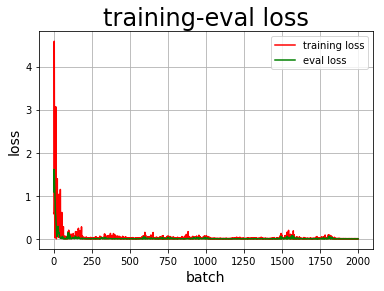

In [60]:
import paddle
# place = fluid.CUDAPlace(0) #非develop版本请勿使用GPU版本
place = fluid.CPUPlace()

with fluid.dygraph.guard(place):
    model=MyLSTMModel() #模型实例化
    # model=MyModel()
    model.train() #训练模式
    # opt=fluid.optimizer.SGDOptimizer(learning_rate=0.001, parameter_list=model.parameters())#优化器选用SGD随机梯度下降，学习率为0.001.
    opt=fluid.optimizer.AdamOptimizer(learning_rate=0.01, parameter_list=model.parameters()) 
    epochs_num=200#迭代次数
    batch_size = 128*3
    train_reader = fluid.io.batch(reader=switch_reader(), batch_size=batch_size)
    val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=batch_size)
    Batch=0
    Batchs=[]
    all_train_loss=[]
    all_eval_loss=[]
    for pass_num in range(epochs_num):
        for batch_id, data in enumerate(train_reader()): 
            data_x=np.array([x[0] for x in data],np.float32)
            data_y = np.array([x[1] for x in data]).astype('float32')
            data_x = fluid.dygraph.to_variable(data_x)
            data_y = fluid.dygraph.to_variable(data_y)
        
            # print(data_x.shape, data_y.shape)

            predict=model(data_x)
            # print(predict.shape)
            loss=fluid.layers.mse_loss(predict,data_y)
            avg_loss=fluid.layers.mean(loss)#获取loss值
            avg_loss.backward()       
            opt.minimize(avg_loss)    #优化器对象的minimize方法对参数进行更新 
            model.clear_gradients()   #model.clear_gradients()来重置梯度
            if batch_id!=0 and batch_id%1==0:
                Batch = Batch+1 
                Batchs.append(Batch)
                all_train_loss.append(avg_loss.numpy()[0])
                evalavg_loss=[]
                for eval_data in val_reader():
                    eval_data_x = np.array([x[0] for x in eval_data],np.float32)
                    eval_data_y = np.array([x[1] for x in eval_data]).astype('float32')

                    eval_data_x = fluid.dygraph.to_variable(eval_data_x)
                    eval_data_y = fluid.dygraph.to_variable(eval_data_y)

                    eval_predict=model(eval_data_x)
                    eval_loss=fluid.layers.mse_loss(eval_predict,eval_data_y)
                    eval_loss=fluid.layers.mean(eval_loss)
                    evalavg_loss.append(eval_loss.numpy()[0])#获取loss值
                all_eval_loss.append(sum(evalavg_loss)/len(evalavg_loss))
        print("epoch:{},batch_id:{},train_loss:{},eval_loss:{}".format(pass_num,batch_id,avg_loss.numpy(),sum(evalavg_loss)/len(evalavg_loss)))     

    fluid.save_dygraph(model.state_dict(),'MyLSTMModel')#保存模型
    fluid.save_dygraph(opt.state_dict(),'MyLSTMModel')#保存模型
    print("Final loss: {}".format(avg_loss.numpy()))    
#让我们绘制训练图和验证损失图，以了解训练的进行情况。     
draw_train_loss(Batchs,all_train_loss,all_eval_loss)

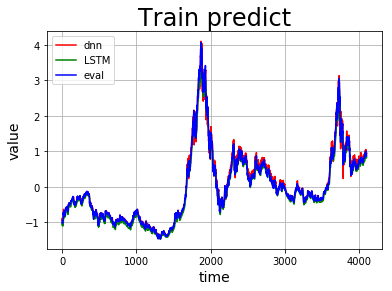

In [58]:
import paddle
# place = fluid.CUDAPlace(0) #非develop版本请勿使用GPU版本
place = fluid.CPUPlace()

with fluid.dygraph.guard(place):
    accs = []
    dnn_predict = []
    model_lstm_dict, _ = fluid.load_dygraph('MyLSTMModel.pdopt')
    model_dnn_dict, _ = fluid.load_dygraph('MyModel.pdopt')
    model_lstm = MyLSTMModel()
    model_dnn = MyModel()
    model_lstm.load_dict(model_lstm_dict)
    model_dnn.load_dict(model_dnn_dict) #加载模型参数

    train_reader = fluid.io.batch(reader=switch_reader(is_val=False), batch_size=train.shape[0])
    train_data_x = np.array([x[0] for x in next(train_reader())],np.float32)
    train_data_y = np.array([x[1] for x in next(train_reader())]).astype('float32')

    train_data_x = fluid.dygraph.to_variable(train_data_x)
    train_data_y = fluid.dygraph.to_variable(train_data_y)

    train_dnn=model_dnn(train_data_x)
    train_lstm=model_lstm(train_data_x)

title="Train predict"
plt.title(title, fontsize=24)
plt.xlabel("time", fontsize=14)
plt.ylabel("value", fontsize=14)
plt.plot(range(train.shape[0]), train_dnn.numpy(), color='red', label='dnn')
plt.plot(range(train.shape[0]), train_lstm.numpy(), color='g', label='LSTM')
plt.plot(range(train.shape[0]), train_data_y.numpy(), color='b', label='eval')
plt.legend()
plt.grid()
plt.show()

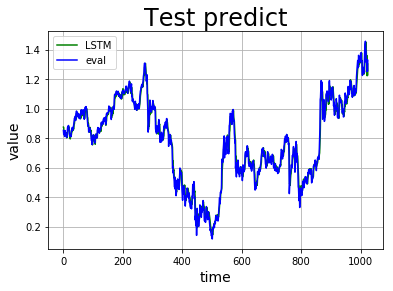

In [69]:
import paddle
# place = fluid.CUDAPlace(0) #非develop版本请勿使用GPU版本
place = fluid.CPUPlace()

with fluid.dygraph.guard(place):
    accs = []
    dnn_predict = []
    model_lstm_dict, _ = fluid.load_dygraph('MyLSTMModel.pdopt')
    model_dnn_dict, _ = fluid.load_dygraph('MyModel.pdopt')
    model_lstm = MyLSTMModel()
    model_dnn = MyModel()
    model_lstm.load_dict(model_lstm_dict)
    model_dnn.load_dict(model_dnn_dict) #加载模型参数

    val_reader = fluid.io.batch(reader=switch_reader(is_val=True), batch_size=test.shape[0])
    # print(len(next(val_reader())))
    eval_data_x = np.array([x[0] for x in next(val_reader())],np.float32)
    eval_data_y = np.array([x[1] for x in next(val_reader())]).astype('float32')

    eval_data_x = fluid.dygraph.to_variable(eval_data_x)
    eval_data_y = fluid.dygraph.to_variable(eval_data_y)

    eval_dnn=model_dnn(eval_data_x)
    eval_lstm=model_lstm(eval_data_x)

title="Test predict"
plt.title(title, fontsize=24)
plt.xlabel("time", fontsize=14)
plt.ylabel("value", fontsize=14)
# plt.plot(range(1025), eval_dnn.numpy(), color='red', label='dnn')
plt.plot(range(1025), eval_lstm.numpy(), color='g', label='LSTM')
plt.plot(range(1025), eval_data_y.numpy(), color='b', label='eval')
plt.legend()
plt.grid()
plt.savefig('test.png', dpi=600)
plt.show()
